Partially from https://keras.io/examples/timeseries/timeseries_transformer_classification/

### Load the Dataset


FordA
- This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. 
- The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. 
- Each case consists of 500 measurements of engine noise and a classification. 
- There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

![fordA](./figure/FordA.png)

### check data

In [1]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

In [2]:
data = np.loadtxt(root_url +"FordA_TRAIN.tsv", delimiter="\t")

In [3]:
data.shape

(3601, 501)

In [4]:
data[0].shape

(501,)

In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame(data)
df.head()
#print(df.shape)

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [7]:
x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [8]:
print(x_train.shape, y_train.shape)

(3601, 500) (3601,)


In [9]:
print(x_test.shape, y_test.shape)

(1320, 500) (1320,)


In [10]:
n_classes = len(np.unique(y_train))
print(n_classes, np.unique(y_train))


2 [-1  1]


In [11]:
print( np.sum(y_train == -1), np.sum(y_train == 1))
print( np.sum(y_test == -1), np.sum(y_test == 1))

1846 1755
681 639


In [12]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Check dataset shape

In [13]:
print(x_train.shape)
print(x_test.shape)

(3601, 500, 1)
(1320, 500, 1)


Shuffling datasets

In [14]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [15]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3601, 500, 1) (3601,)
(1320, 500, 1) (1320,)


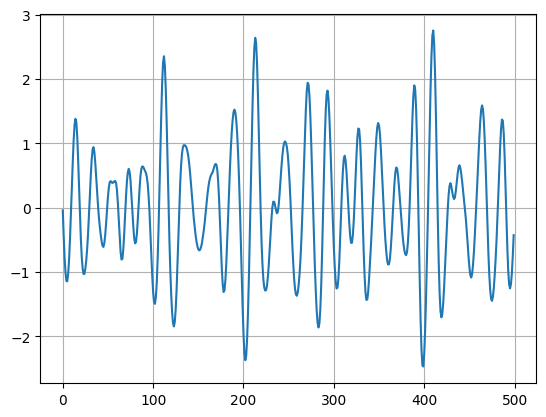

In [16]:
import matplotlib.pyplot as plt
#Lets plot a  data
indices = np.where(y_train == 1)
plt.plot(np.arange(500), x_train[indices[0][4]])
plt.grid()
plt.show()

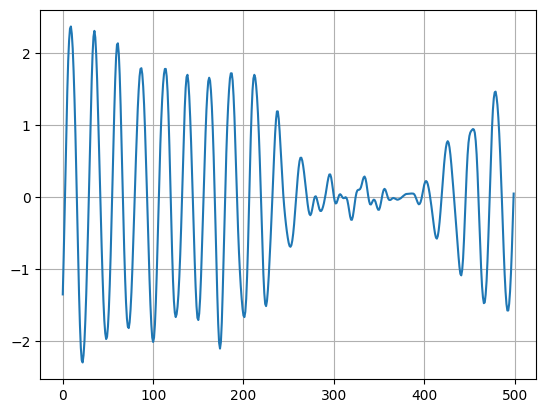

In [17]:
import matplotlib.pyplot as plt
#Lets plot a  data
indices = np.where(y_train == 0)
plt.plot(np.arange(500), x_train[indices[0][-10]])
plt.grid()
plt.show()

#### Build a model

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

![transfomer1](./figure/transformer.png)

- Attention mechanism instead of convolutional or recurrent units

- Global dependencies between input and output

- More parallelization

- Reduced effective resolution



![trans2](./figure/transformer2.png)

- Parallel encoder + autoregressive decoder
- Positioanl encoding, skip connection, layer normalizatoin, dropout

Encoder consistes of N = 6 identical layers
- 1st sublayer : multi-head self attention
- 2nd sublayer : position-wise fully connected(FC) layer
- Residual Connection + layer norm (LayerNorm ( x + sublayer(x))

In all sublayers, d_model = 512

In [19]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [20]:
def build_model(
    input_shape,
    head_size, 
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [21]:
x_train.shape # (datasize, timestep, features)

(3601, 500, 1)

In [22]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=1,
    num_transformer_blocks=1,
    mlp_units=[32],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 500, 1)      449         ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

#### Train the model

In [23]:
training = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)


model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
45/45 [==============================] - 2s 15ms/step - loss: 1.0997 - sparse_categorical_accuracy: 0.5181 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.5187
Epoch 2/200
45/45 [==============================] - 0s 10ms/step - loss: 0.9788 - sparse_categorical_accuracy: 0.5278 - val_loss: 0.7897 - val_sparse_categorical_accuracy: 0.5381
Epoch 3/200
45/45 [==============================] - 0s 10ms/step - loss: 0.9407 - sparse_categorical_accuracy: 0.5385 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.5562
Epoch 4/200
45/45 [==============================] - 0s 10ms/step - loss: 0.8788 - sparse_categorical_accuracy: 0.5663 - val_loss: 0.7273 - val_sparse_categorical_accuracy: 0.5770
Epoch 5/200
45/45 [==============================] - 0s 10ms/step - loss: 0.8394 - sparse_categorical_accuracy: 0.5760 - val_loss: 0.7048 - val_sparse_categorical_accuracy: 0.5825
Epoch 6/200
45/45 [==============================] - 0s 10ms/step - loss: 0.8189 - sparse_categorica

[0.396648108959198, 0.835606038570404]


And that is for a model with less than 100k parameters. 
Of course, parameter count and accuracy could be improved by a hyperparameter search and a more sophisticated learning rate schedule, or a different optimizer.

training accuracy of ~0.88, validation accuracy of ~83 and a testing accuracy of ~85,

#### plot training and validation loss 

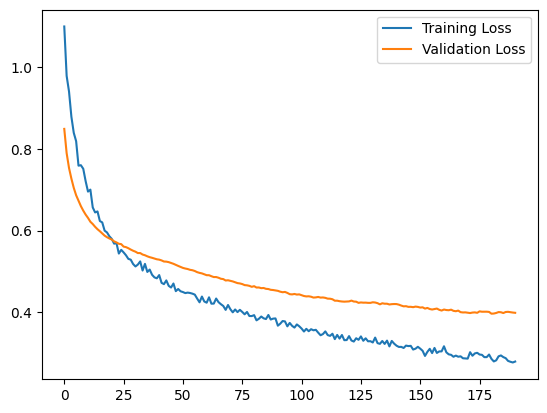

In [24]:
plt.plot(training.history["loss"], label="Training Loss")
plt.plot(training.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [26]:
test_scores = model.evaluate(x_test, y_test, verbose = 2)

42/42 - 0s - loss: 0.3966 - sparse_categorical_accuracy: 0.8356 - 164ms/epoch - 4ms/step


In [31]:
test_scores # loss, accuracy

[0.396648108959198, 0.835606038570404]

In [29]:
print('Test loss: {}'.format(test_scores[0]))
print('Accuracy: {} %'.format(test_scores[1]*100))

Test loss: 0.396648108959198
Accuracy: 83.5606038570404 %


In [49]:
model.predict(x_test)

42/42 [==============================] - 0s 3ms/step


array([[0.9109155 , 0.08908449],
       [0.96257246, 0.03742755],
       [0.22597057, 0.7740295 ],
       ...,
       [0.22738615, 0.7726139 ],
       [0.64153045, 0.35846955],
       [0.61636746, 0.3836325 ]], dtype=float32)